#### Introducción al aprendizaje profundo
#### Giovanni Gamaliel López Padilla
##### Tarea 01

###### Versiones utilizadas
```bash
numpy == 1.22.3
tabulate == 0.8.9
pandas == 1.3.5
```

##### Bases

Se tomaron los datos diarios de radiación UV recopilados por las estaciones meteorologicas de la SEDEMA  durante el periodo 2000 - 2020(http://www.aire.cdmx.gob.mx/default.php?opc=%27aKBhnmI=%27&opcion=bA). A partir de las mediciones diarias se calculo el promedio mensual. 

Los meses consecutivos serán denotadas por $x$ y los promedios mensuales por $y$. Se propuso una función radial que interpolará los valores de $y$. El valor dependera de la distancia del punto y el centro $c$. La interpolación es descrita como una combinación lineal de las funciones radiales. Esto es

$$
y = \sum_{j=1}^n \alpha_j \phi_j(x) \nonumber
$$

donde 

$$
\phi_j(x)= \phi\left (-\frac{1}{2\sigma^2} ||x-\mu_j||^2\right) \nonumber
$$

Por lo que se obtará por minimízar los vectores $\alpha$ y $\mu$. Esto es

$$
\underset{\alpha,\mu}{min} \frac{1}{2} ||\Phi(\mu)\alpha-y||^2_2 \nonumber
$$

donde 

$$
\Phi(\mu) = [\phi_1,\phi_2,\dots,\phi_n] \nonumber
$$

con 

$$
\phi_{ij} = exp\left(-\frac{1}{2\sigma^2}(x_i-\mu_j)^2 \right)
$$

###### Organizacion de archivos

El trabajo se desarrollo usando archivos .py para ser adjuntados en un solo notebook

```bash
├── Data
│  └── data.csv
├── Modules
│  ├── datasets.py
│  ├── functions.py
│  ├── models.py
│  └── solver.py
├── Results
│  ├── ADADELTA.csv
│  ├── ADAM.csv
│  ├── NAG.csv
│  └── SGD.csv
├── Graphics.py
└── run.py
```

In [1]:
from os import makedirs as mkdir


def obtain_all_params() -> dict:
    """
    Funcion que reune los parámtros de la función y el gradiente. Devuelve estos dos parámetros en forma de diccionarios.
    """
    params = {
        "path data": "Data",
        "path results": "Results",
        "file data": "data.csv",
        "data column": "Max",
        "models": {
            "SGD": "#f72585",
            "NAG": "#3a0ca3",
            "ADAM": "#d00000",
            "ADADELTA": "#006400",
        },
        "n": 120,
        "max iteration": 100,
        "m": 36,
        "sigma": 4.8,
    }

    # parámetros del algoritmo
    gd_params = {
        'alpha': 1e-4,
        'alphaADADELTA': 1e-3,
        'alphaADAM': 0.95,
        'nIter': 300,
        'batch_size': 500,
        'eta': 0.9,
        'eta1': 0.9,
        'eta2': 0.999
    }
    mkdir(params["path results"],
          exist_ok=True)
    return params, gd_params

In [2]:
from numpy import exp, ones, array, outer
from tabulate import tabulate
from pandas import DataFrame
from os.path import join


def print_results(params: dict, results: array) -> None:
    table = []
    for model_name in params["models"]:
        time = results[model_name]["time"]
        error = results[model_name]["error"]
        table += [[model_name, time, error]]
    print(tabulate(table,
                   headers=["Model",
                            "Time",
                            "Error"]))


def write_results(params: dict, model: str) -> None:
    filename = "{}.csv".format(model)
    filename = join(params["path results"],
                    filename)
    data = DataFrame()
    data["alpha"] = params["alpha"]
    data["mu"] = params["mu"]
    data.to_csv(filename,
                index=False)


class function_class:
    def __init__(self) -> None:
        pass

    def phi(self, x: array, mu: array, sigma: array) -> array:
        """


        Parámetros
        -----------
        x -> Patrones a Aproximar
        mu -> Array de medias
        sigma -> Vector de Desviacionesalpha
        -----------
        phi          : matriz de kerneles
        """
        x = x.reshape((-1, 1))
        mu = mu.reshape((-1, 1))
        phi = exp(-(x-mu.T)**2/(2*sigma**2))
        return phi

    def gradient_gaussian_mu(self, mu: None, f_params: dict) -> array:
        """
        Calcula el gradiente respecto a mu
        Parámetros
        -----------
        theta
        f_params -> lista de parametros para la funcion objetivo,
        X = f_params['X'] Variable independiente
        y = f_params['y'] Variable dependiente

        Output
        -----------
            Array gradiente
        """
        # Obtengo Parámetros
        x = f_params['x']
        alpha = f_params['alpha']
        n = x.shape
        m = f_params["m"]
        m = alpha.shape
        y = f_params['y']
        # print(n, m)
        sigma = f_params["sigma"]
        phi = self.phi(x, mu, sigma)
        Alpha = outer(ones(n), alpha)
        beta = outer(x, ones(m))-outer(ones(n), mu)
        gradient = (phi*Alpha*beta).T @ (phi@alpha-y)
        gradient = gradient/sigma**2
        return gradient

    def gradient_gaussian_alpha(self, alpha: array, f_params: dict) -> array:
        """
        Calcula el gradiente respecto a alpha
        Parámetros
        -----------
            theta
            f_params : lista de parametros para la funcion objetivo,
                        X -> f_params['X'] Variable independiente
                        y -> f_params['y'] Variable dependiente

        Output
        -----------
            Array gradiente
        """
        # Obtengo Parámetros
        x = f_params['x']
        y = f_params['y']
        mu = f_params["mu"]
        sigma = f_params["sigma"]
        phi = self.phi(x, mu, sigma)
        gradient = phi.T @ (phi @ alpha - y)
        #gradient = phi.T @ phi @ alpha - phi.T @ y
        return gradient

In [3]:
from numpy import array, zeros, sqrt
from numpy.random import randint


class model_class:
    def __init__(self) -> None:
        """
        Modelo que reune los metodos de
        + Descenso de gradiente estocástico.
        + Descenso de gradiente estoc ́astico accelerado de tipo Nesterov.
        + AdaDelta
        + ADAM
        """
        pass

    def select_method(self, method_name: str):
        if method_name == "SGD":
            self.method = self.SGD
        if method_name == "NAG":
            self.method = self.NAG
        if method_name == "ADADELTA":
            self.method = self.ADADELTA
        if method_name == "ADAM":
            self.method = self.ADAM

    def SGD(self, theta: list, grad, gd_params: dict, f_params: dict,) -> array:
        """
        Descenso de gradiente estocástico

        Parámetros
        -----------
        theta     :   condicion inicial
        grad      :   funcion que calcula el gradiente

        gd_params :   lista de parametros para el algoritmo de descenso,
                        nIter = gd_params['nIter'] número de iteraciones
                        alpha = gd_params['alpha'] tamaño de paso alpha
                        batch_size = gd_params['batch_size'] tamaño de la muestra

        f_params  :   lista de parametros para la funcion objetivo,
                        X     = f_params["x"] Variable independiente
                        y     = f_params['y'] Variable dependiente

        Output
        -----------
        Theta     :   trayectoria de los parametros
                        Theta[-1] es el valor alcanzado en la ultima iteracion
        """
        high = f_params["x"].shape
        batch_size = gd_params['batch_size']
        nIter = gd_params['nIter']
        alpha = gd_params['alpha']
        Theta = []
        for t in range(nIter):
            # Set of sampled indices
            smpIdx = randint(low=0,
                             high=high,
                             size=batch_size,
                             dtype='int32')
            # sample
            smpX = f_params['x'][smpIdx]
            smpy = f_params['y'][smpIdx]
            # parametros de la funcion objetivo
            smpf_params = {"alpha": f_params["alpha"],
                           "mu": f_params["mu"],
                           "m": f_params["m"],
                           "sigma": f_params["sigma"],
                           "n": f_params["n"],
                           "x": smpX,
                           'y': smpy}
            p = grad(theta,
                     f_params=smpf_params)
            theta = theta - alpha*p
            Theta.append(theta)
        return array(Theta)

    def NAG(self, theta: list, grad, gd_params: dict, f_params: dict,):
        """
        Descenso acelerado de Nesterov

        Parámetros
        -----------
        theta     :   condicion inicial
        grad      :   funcion que calcula el gradiente
        gd_params :   lista de parametros para el algoritmo de descenso,
                        nIter = gd_params['nIter'] número de iteraciones
                        alpha = gd_params['alpha'] tamaño de paso alpha
                        eta   = gd_params['eta']  parametro de inercia (0,1]
        f_params  :   lista de parametros para la funcion objetivo,
                        X     = f_params["x"] Variable independiente
                        y     = f_params['y'] Variable dependiente

        Output
        -----------
        Theta     :   trayectoria de los parametros
                        Theta[-1] es el valor alcanzado en la ultima iteracion
        """
        nIter = gd_params['nIter']
        alpha = gd_params['alpha']
        eta = gd_params['eta']
        p = zeros(theta.shape)
        Theta = []
        for t in range(nIter):
            pre_theta = theta - 2.0*alpha*p
            g = grad(pre_theta,
                     f_params=f_params)
            p = g + eta*p
            theta = theta - alpha*p
            Theta.append(theta)
        return array(Theta)

    def ADADELTA(self, theta: list, grad, gd_params: dict, f_params: dict,):
        """
        Descenso de Gradiente Adaptable (ADADELTA)

        Parámetros
        -----------
        theta     :   condicion inicial
        grad      :   funcion que calcula el gradiente
        gd_params :   lista de parametros para el algoritmo de descenso,
                        nIter    = gd_params['nIter'] número de iteraciones
                        alphaADA = gd_params['alphaADADELTA'] tamaño de paso alpha
                        eta      = gd_params['eta']  parametro adaptación del alpha
        f_params  :   lista de parametros para la funcion objetivo,
                        X     = f_params["x"] Variable independiente
                        y     = f_params['y'] Variable dependiente

        Output
        -----------
        Theta     :   trayectoria de los parametros
                        Theta[-1] es el valor alcanzado en la ultima iteracion
        """
        epsilon = 1e-8
        nIter = gd_params['nIter']
        alpha = gd_params['alphaADADELTA']
        eta = gd_params['eta']
        G = zeros(theta.shape)
        g = zeros(theta.shape)
        Theta = []
        for t in range(nIter):
            g = grad(theta,
                     f_params=f_params)
            G = eta*g**2 + (1-eta)*G
            p = 1.0/(sqrt(G)+epsilon)*g
            theta = theta - alpha * p
            Theta.append(theta)
        return array(Theta)

    def ADAM(self, theta: list, grad, gd_params: dict, f_params: dict,):
        """
        Descenso de Gradiente Adaptable con Momentum(A DAM)

        Parámetros
        -----------
        theta     :   condicion inicial
        grad      :   funcion que calcula el gradiente
        gd_params :   lista de parametros para el algoritmo de descenso,
                        nIter    = gd_params['nIter'] número de iteraciones
                        alphaADA = gd_params['alphaADAM'] tamaño de paso alpha
                        eta1     = gd_params['eta1'] factor de momentum para la direccion
                                    de descenso (0,1)
                        eta2     = gd_params['eta2'] factor de momentum para la el
                                    tamaño de paso (0,1)
        f_params  :   lista de parametros para la funcion objetivo,
                        kappa = f_params['kappa'] parametro de escala (rechazo de outliers)
                        X     = f_params["x"] Variable independiente
                        y     = f_params['y'] Variable dependiente

        Output
        -----------
        Theta     :   trayectoria de los parametros
                        Theta[-1] es el valor alcanzado en la ultima iteracion
        """
        epsilon = 1e-8
        nIter = gd_params['nIter']
        alpha = gd_params['alphaADAM']
        eta1 = gd_params['eta1']
        eta2 = gd_params['eta2']
        p = zeros(theta.shape)
        v = 0.0
        Theta = []
        eta1_t = eta1
        eta2_t = eta2
        for t in range(nIter):
            g = grad(theta,
                     f_params=f_params)
            p = eta1*p + (1.0-eta1)*g
            v = eta2*v + (1.0-eta2)*(g**2)
            theta = theta - alpha * p / (sqrt(v)+epsilon)
            eta1_t *= eta1
            eta2_t *= eta2
            Theta.append(theta)
        return array(Theta)

In [4]:
from numpy.random import rand
from numpy import linspace
import time


def solver(models: model_class, params: dict, gd_params: dict) -> tuple:
    """
    Funcion que ejecuta un algoritmo para realizar la optimización de la función dado un diccionario de parametros

    Parámetros
    -----------------------
    models -> modelo que contiene los métodos de optimización de parámetros
    y -> patrones a aproximar
    params -> diccionario que contiene los parametros de las iteraciones
    gd_params -> diccionario que contiene los parametros del modelo
    """
    max_iteration = params["max iteration"]
    sigma = params["sigma"]
    n = params["n"]
    m = params["m"]
    x = params["x"]
    y = params["y"]
    functions = function_class()
    t_init = time.clock_gettime(0)
    # Valores Iniciales
    mu = linspace(0, x[-1], m)
    alpha = rand(m)
    # Parámetros para el gradiente
    f_params = {
        'mu': mu,
        'x': x,
        'y': y,
        "m": m,
        'alpha': alpha,
        "sigma": sigma,
        'n': n
    }
    iteration = 0
    while iteration < max_iteration:
        # descenso para alpha
        alpha = models.method(alpha,
                              grad=functions.gradient_gaussian_alpha,
                              gd_params=gd_params,
                              f_params=f_params)[-1]
        f_params["alpha"] = alpha
        # descenso para mu
        mu = models.method(mu,
                           grad=functions.gradient_gaussian_mu,
                           gd_params=gd_params,
                           f_params=f_params)[-1]
        # Criterio de parada
        f_params["mu"] = mu
        # Número máximo de iteraciones si no hay convergencia
        iteration += 1
    params["mu"] = mu
    params["alpha"] = alpha
    t_end = time.clock_gettime(0)
    total_time = t_end - t_init
    return total_time

In [5]:
from numpy import array, linspace
from pandas import read_csv
from os.path import join

results = {}
function = function_class()
params, gd_params = obtain_all_params()
models = model_class()
filename = join(params["path data"],
                params["file data"])
y = read_csv(filename)
y = y.dropna(axis=0)
y = array(y[params["data column"]])
params["n"] = len(y)
x = linspace(1, params["n"], params["n"])
params["x"] = x
params["y"] = y
for model_name in params["models"]:
    print("Resolviendo por medio de {}".format(model_name))
    results[model_name] = {}
    models.select_method(model_name)
    time_solver = solver(models, params, gd_params)
    phi = function.phi(x, params["mu"], params["sigma"])
    error = round(((phi @ params["alpha"] - y)**2).mean(), 8)
    results[model_name]["time"] = time_solver
    results[model_name]["error"] = error
    write_results(params,
                  model_name)
print_results(params, results)

Resolviendo por medio de SGD
Resolviendo por medio de NAG
Resolviendo por medio de ADAM
Resolviendo por medio de ADADELTA
Model        Time    Error
--------  -------  -------
SGD       58.4202  1.09742
NAG       13.5492  1.0054
ADAM      14.348   1.10126
ADADELTA  13.982   0.93763


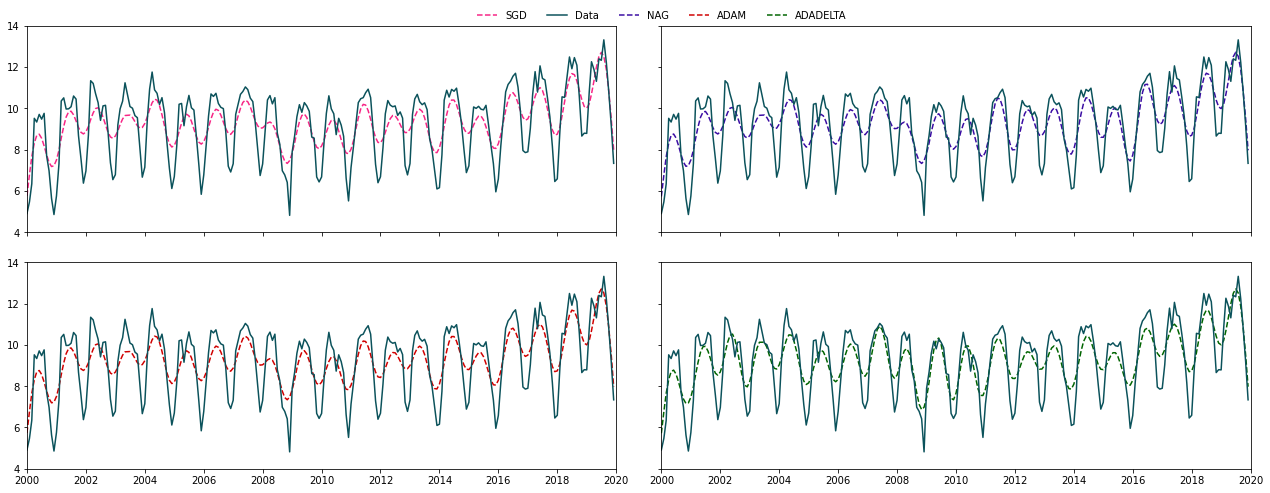

In [6]:
from pandas import read_csv, to_datetime
from numpy import array, linspace
import matplotlib.pyplot as plt
from os.path import join

params, gd_params = obtain_all_params()
function = function_class()
filename = join(params["path data"],
                params["file data"])
data = read_csv(filename,
                index_col=0,
                parse_dates=[0])
data = data.dropna(axis=0)
data = data[params["data column"]]
fig, axs = plt.subplots(2, 2,
                        sharex=True,
                        sharey=True,
                        figsize=(18, 7))
axs = axs.flatten()
for ax, model_name in zip(axs, params["models"]):
    filename = "{}.csv".format(model_name)
    filename = join(params["path results"],
                    filename)
    data_model = read_csv(filename)
    alpha = array(data_model["alpha"])
    mu = array(data_model["mu"])
    x = linspace(1, len(data), len(data))
    phi = function.phi(x, mu, params["sigma"])
    ax.plot(data.index,
            phi@alpha,
            label=model_name,
            ls="--",
            color=params["models"][model_name])
    ax.plot(data.index,
            data,
            label="Data",
            color="#0b525b")
ax.set_xlim(to_datetime("2000-01-01"),
            to_datetime("2020-01-01"))
ax.set_ylim(4, 14)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(label, []) for label in zip(*lines_labels)]
by_label = dict(zip(labels, lines))
fig.legend(by_label.values(),
           by_label.keys(),
           frameon=False,
           ncol=5,
           bbox_to_anchor=(0.67, 1))
plt.tight_layout(pad=2)
plt.show()